<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/10_minutes_to_PandasAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PandasAI
PandasAI is a library that makes data analysis conversational and fun again. It leverages the power of pandas dataframes combined to the most advanced LLMs to let users to data analysis in a conversational way.

Similarly to what `pandas` has done (10 minutes to pandas -> https://pandas.pydata.org/docs/user_guide/10min.html), we wanted to create the most straightforward way to learn how to master PandasAI.

Let's start!


## Setup
To get started, we need to install the last version of PandasAI.

In [ ]:
!pip install pandasai

# SmartDataframe

A SmartDataframe is a pandas (or polars) dataframe that inherits all the properties and methods from the `pd.DataFrame`, but also adds conversational features to it.

In [ ]:
from pandasai import SmartDataframe

You can instantiate a dataframe importing from several different sources (pandas or polars dataframe, csv, xlsx or google sheets).

### Importing from a pandas dataframe

To import from a pandas dataframe, you need to import the pandas libraries and create a dataframe first.

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({
    "country": [
        "United States",
        "United Kingdom",
        "France",
        "Germany",
        "Italy",
        "Spain",
        "Canada",
        "Australia",
        "Japan",
        "China",
    ],
    "gdp": [
        19294482071552,
        2891615567872,
        2411255037952,
        3435817336832,
        1745433788416,
        1181205135360,
        1607402389504,
        1490967855104,
        4380756541440,
        14631844184064,
    ],
    "happiness_index": [6.94, 7.16, 6.66, 7.07, 6.38, 6.4, 7.23, 7.22, 5.87, 5.12],
})

Since PandasAI is powered by a LLM, you should import the LLM you'd like to use for your use case. In thic case we're gonna use OpenAI.

To use OpenAI, you'll need a API token. Follow below simple steps to generate your API_TOKEN with
[openai](https://platform.openai.com/overview).

1. Go to  https://openai.com/api/ and signup with your email address or connect your Google Account.
2. Go to View API Keys on left side of your Personal Account Settings
3. Select Create new Secret key

> The API access to openai is a paid service. You have to set up billing.
>Read the [Pricing](https://platform.openai.com/docs/quickstart/pricing) information before experimenting.

In [ ]:
from pandasai.llm import OpenAI

llm = OpenAI(api_token="YOUR TOKEN")

Now that we have instantiated the LLM, we can finally instantiate the `SmartDataframe`

In [ ]:
sdf = SmartDataframe(df, config={"llm": llm})

You can now query it in natural language

In [ ]:
sdf.chat("Return the top 5 countries by GDP")

,country,gdp,happiness_index
0,United States,19294482071552,6.94
9,China,14631844184064,5.12
8,Japan,4380756541440,5.87
3,Germany,3435817336832,7.07
1,United Kingdom,2891615567872,7.16


In [ ]:
sdf.chat("What's the sum of the gdp of the 2 unhappiest countries?")

19012600725504

In [ ]:
print(sdf.last_code_generated)

def analyze_data(dfs: list[pd.DataFrame]) ->dict:
    df_combined = pd.concat(dfs)
    df_sorted = df_combined.sort_values('happiness_index')
    sum_gdp = df_sorted.head(2)['gdp'].sum()
    return {'type': 'number', 'value': sum_gdp}


result = analyze_data(dfs)


### Plotting a chart

You can also use PandasAI to easily plot a chart

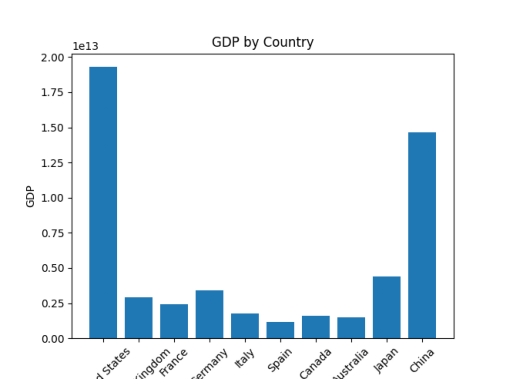

In [ ]:
sdf.chat("Plot a chart of the gdp by country")

You can also provide additional instructions. For example, imagine you want to use different colors for each bar. You just need to ask to PandasAI:

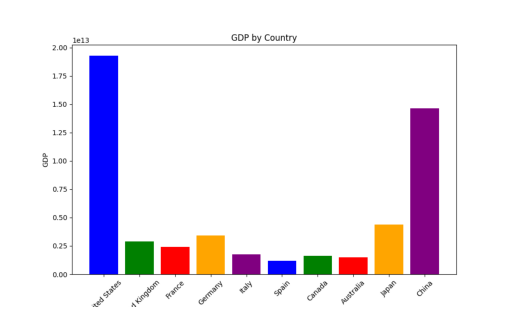

In [ ]:
sdf.chat("Plot a histogram of the gdp by country, using a different color for each bar")

# SmartDatalake

Sometimes, you might want to work with multiple dataframes at a time, letting the LLM orchestrate which one(s) to use to answer your queries. In such cases, instead of using a `SmartDataframe` you should rather use a `SmartDatalake`.

The concept is very similar to the `SmartDataframe`, but instead of accepting only 1 df as input, it can accept multiple ones.

In [ ]:
from pandasai import SmartDatalake

For example, in this example, we are provided with 2 different dfs.
In the first one, it's reported for each employee, an employee id, a name and a department.
In the second one, instad, it's provided the employee id and the salary for each employee.

Asking PandasAI, it will join the 2 different dataframes by id and figure out the name of the one that is paid the most.

In [ ]:
employees_df = pd.DataFrame(
    {
        "EmployeeID": [1, 2, 3, 4, 5],
        "Name": ["John", "Emma", "Liam", "Olivia", "William"],
        "Department": ["HR", "Sales", "IT", "Marketing", "Finance"],
    }
)

salaries_df = pd.DataFrame(
    {
        "EmployeeID": [1, 2, 3, 4, 5],
        "Salary": [5000, 6000, 4500, 7000, 5500],
    }
)

lake = SmartDatalake(
    [employees_df, salaries_df],
    config={"llm": llm}
)
lake.chat("Who gets paid the most?")

'The employee who gets paid the most is Olivia.'

Here's an example of the code that is generated:

In [ ]:
print(lake.last_code_executed)

def analyze_data(dfs: list[pd.DataFrame]) ->dict:
    """
    Analyze the data
    1. Prepare: Preprocessing and cleaning data if necessary
    2. Process: Manipulating data for analysis (grouping, filtering, aggregating, etc.)
    3. Analyze: Conducting the actual analysis (if the user asks to plot a chart save it to an image in exports/charts/temp_chart.png and do not show the chart.)
    4. Output: return a dictionary of:
    - type (possible values "text", "number", "dataframe", "plot")
    - value (can be a string, a dataframe or the path of the plot, NOT a dictionary)
    Example output: { "type": "text", "value": "The average loan amount is $15,000." }
    """
    merged_df = pd.merge(dfs[0], dfs[1], on='EmployeeID')
    max_salary_employee = merged_df.loc[merged_df['Salary'].idxmax()]
    employee_name = max_salary_employee['Name']
    return {'type': 'text', 'value': f'The employee who gets paid the most is {employee_name}.'}


Ok in this case it was easy: both the tables are share a common value called `EmployeeID`, right?

Let's try with something more complex

In [ ]:
users_df = pd.DataFrame(
    {
        "id": [1, 2, 3, 4, 5],
        "name": ["John", "Emma", "Liam", "Olivia", "William"]
    }
)
users = SmartDataframe(users_df, name="users")

photos_df = pd.DataFrame(
    {
        "id": [31, 32, 33, 34, 35],
        "user_id": [1, 1, 2, 4, 5]
    }
)
photos = SmartDataframe(photos_df, name="photos")

lake = SmartDatalake([users, photos], config={"llm": llm})
lake.chat("How many photos has been uploaded by John?")

2

In this case we provided for each df a table name, so that the LLM has some context and can better perform the joins. As you can see on the example below, it succeeded at figuring out the right join to do. In fact, the user "John" has actually 2 photos.

In [ ]:
print(lake.last_code_executed)

def analyze_data(dfs: list[pd.DataFrame]) ->dict:
    users = dfs[0]
    photos = dfs[1]
    merged_df = pd.merge(users, photos, left_on='id', right_on='user_id')
    john_photos = merged_df[merged_df['name'] == 'John']
    num_photos = john_photos.shape[0]
    return {'type': 'number', 'value': num_photos}


result = analyze_data(dfs)


# Different LLMs

Although at the moment OpenAI GPT3.5 and GPT4 are the recommended models, we also support other models, like AzureOpenAI.

You can use them as if follows:

In [ ]:
from pandasai import SmartDataframe
from pandasai.llm import Starcoder, Falcon
from pandasai.llm import AzureOpenAI
from pandasai.llm import GoogleVertexAI

azure_llm = AzureOpenAI(
    api_token="my-azure-openai-api-key",
    azure_endpoint="my-azure-openai-api-endpoint",
    api_version="2023-05-15",
    deployment_name="my-deployment-name"
)

vertexai_llm = GoogleVertexAI(
  project_id="generative-ai-training",
  location="us-central1",
  model="text-bison@001"
)

df1 = SmartDataframe(df, config={"llm": azure_llm})
df2 = SmartDataframe(df, config={"llm": vertexai_llm})

print(df1.chat("Which country has the highest GDP?"))
print(df2.chat("Which one is the unhappiest country?"))

## LangChain LLMs

In some cases, you might want to use LangChain LLMs instead.

In [ ]:
!pip install pandasai[langchain]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.8 MB/s eta 0:00:00


Then you can use them as if they were PandasAI LLMs.

In [ ]:
from pandasai import SmartDataframe
from langchain.llms import OpenAI
# from langchain.llms import Anthropic
# from langchain.llms import LlamaCpp

langchain_llm = OpenAI(openai_api_key="YOUR TOKEN", max_tokens=1000)
langchain_sdf = SmartDataframe(df, config={"llm": langchain_llm})
langchain_sdf.chat("Which are the top 5 countries by GPD?")

,country,gdp,happiness_index
0,United States,19294482071552,6.94
9,China,14631844184064,5.12
8,Japan,4380756541440,5.87
3,Germany,3435817336832,7.07
1,United Kingdom,2891615567872,7.16


# Connectors

PandasAI provides a number of connectors that allow you to connect to different data sources. These connectors are designed to be easy to use, even if you are not familiar with the data source or with PandasAI.

To use a connector, you first need to install the required dependencies. You can do this by running the following command:

In [ ]:
!pip install pandasai[connectors]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 709.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from pandasai.connectors import MySQLConnector, PostgreSQLConnector

# With a MySQL database
loan_connector = MySQLConnector(
    config={
        "host": "localhost",
        "port": 3306,
        "database": "mydb",
        "username": "root",
        "password": "root",
        "table": "loans",
        "where": [
            # this is optional and filters the data to
            # reduce the size of the dataframe
            ["loan_status", "=", "PAIDOFF"],
        ],
    }
)

# With a PostgreSQL database
payment_connector = PostgreSQLConnector(
    config={
        "host": "localhost",
        "port": 5432,
        "database": "mydb",
        "username": "root",
        "password": "root",
        "table": "payments",
        "where": [
            # this is optional and filters the data to
            # reduce the size of the dataframe
            ["payment_status", "=", "PAIDOFF"],
        ],
    }
)

df_connector = SmartDatalake([loan_connector, payment_connector], config={"llm": llm})
response = df_connector.chat("How many loans from the United states?")
print(response)

In [ ]:
from pandasai.connectors.yahoo_finance import YahooFinanceConnector

yahoo_connector = YahooFinanceConnector("MSFT")
df = SmartDataframe(yahoo_connector, config={"llm": llm})

response = df.chat("What is the closing price for yesterday?")
print(response)

The closing price for yesterday was $319.53.


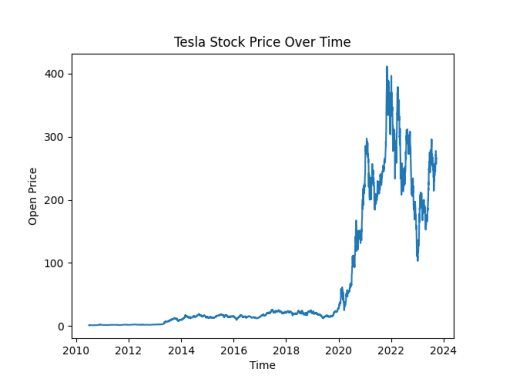

In [ ]:
yahoo_connector = YahooFinanceConnector("TSLA")

df_connector = SmartDataframe(yahoo_connector, config={"llm": llm})
response = df_connector.chat("Plot the chart of tesla over time")

You can find more info about the connectors (and many more connectors) here: https://docs.pandas-ai.com/en/latest/connectors/

# Train PandasAI
You can train PandasAI to understand your data better and to improve its performance. Training is as easy as calling the `train` method on the `SmartDataframe`, `SmartDatalake` or `Agent`.

There are two kinds of training:

- instructions training
- q/a training

## Instructions training

Instructions training is used to teach PandasAI how you expect it to respond to certain queries. You can provide generic instructions about how you expect the model to approach certain types of queries, and PandasAI will use these instructions to generate responses to similar queries.

For example, you might want the LLM to be aware that your company's fiscal year starts in April, or about specific ways you want to handle missing data. Or you might want to teach it about specific business rules or data analysis best practices that are specific to your organization.

To train PandasAI with instructions, you can use the `train` method on the `Agent`, `SmartDataframe` or `SmartDatalake`, as it follows.

** NOTE **: You can get your API KEY from https://PandaBI.ai

In [ ]:
import os

os.environ["PANDASAI_API_KEY"] = "YOUR_PANDASAI_API_KEY"

In [ ]:
from pandasai import Agent
from pandasai.llm import OpenAI

llm = OpenAI()

agent = Agent(df, config={"llm": llm})
agent.train(docs="Exclude the US from the highest GDP")

In [ ]:
response = agent.chat("Which country has the highest GDP?")
print(response)

The country with the highest GDP (excluding the US) is China.


## Q/A training

Q/A training is used to teach PandasAI the desired process to answer specific questions, enhancing the model's performance and determinism. One of the biggest challenges with LLMs is that they are not deterministic, meaning that the same question can produce different answers at different times. Q/A training can help to mitigate this issue.

To train PandasAI with Q/A, you can use the `train` method on the `Agent`, `SmartDataframe` or `SmartDatalake`, as it follows:

In [ ]:
# Train the model
query = "What are the top 5 countries by GDP?"
response = """
import pandas as pd

df = dfs[0]

# Convert GDP column to numeric values
df['gdp'] = pd.to_numeric(df['gdp'])

# Sort the DataFrame by GDP in descending order
sorted_df = df.sort_values(by='gdp', ascending=False)

# Get the top 5 countries by GDP
top_5_countries = sorted_df.head(5)

# Declare result variable
result = {
    "type": "dataframe",
    "value": top_5_countries
}
"""
agent.train(queries=[query], codes=[response])

In [ ]:
response = agent.chat("List the top 10 countries by GDP")
print(response)
print(agent.last_code_generated)

          country             gdp  happiness_index
9           China  14631844184064             5.12
8           Japan   4380756541440             5.87
3         Germany   3435817336832             7.07
1  United Kingdom   2891615567872             7.16
2          France   2411255037952             6.66
4           Italy   1745433788416             6.38
6          Canada   1607402389504             7.23
7       Australia   1490967855104             7.22
5           Spain   1181205135360             6.40
# TODO: import the required dependencies
import pandas as pd

df = dfs[0]

# Convert GDP column to numeric values
df['gdp'] = pd.to_numeric(df['gdp'])

# Sort the DataFrame by GDP in descending order
sorted_df = df.sort_values(by='gdp', ascending=False)

# Get the top 10 countries by GDP (excluding the US)
top_10_countries = sorted_df[sorted_df['country'] != 'United States'].head(10)

# Declare result variable
result = {
    "type": "dataframe",
    "value": top_10_countries
}
